In [1]:
from torchvision import transforms
from torch.utils.data import DataLoader
import pathlib
import sys
import torchmetrics
from torchmetrics.classification import (
    MulticlassAUROC,
    MulticlassJaccardIndex,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
    MulticlassAccuracy,
    BinaryAccuracy,
    BinaryAUROC,
    BinaryF1Score,
    BinaryPrecision,
    BinaryRecall,
    BinaryJaccardIndex,
)
import torch
import torch.nn as nn

root = pathlib.Path().absolute().parent
DATASET_PATH = root / 'datasets'
MODEL_REGISTRY = root / 'model_registry'

sys.path.append(str(root))

from src.data.classification import TumorClassificationDataset, TumorBinaryClassificationDataset, CLASSIFICATION_NORMALIZER
from src.utils.config import get_device
from src.enums import DataSplit
from src.models.classification.cnn import ClassificationMulticlassCNN, ClassificationCNN
from src.trainer import eval_classification, train_classification
from src.utils.visualize import create_classification_results

In [2]:
DIM = 256
N_EPOCHS = 20
BATCH_SIZE = 32

transform = transforms.Compose(
    [
        transforms.Resize((DIM, DIM)),  # TODO: make this larger
        transforms.ToTensor(),
        CLASSIFICATION_NORMALIZER
    ]
)

device = get_device()

CNN_MULTI_MODEL = MODEL_REGISTRY / 'cnn_multi.pth'
CNN_BINARY_MODEL = MODEL_REGISTRY / 'cnn_binary.pth'

def build_model_for_job(is_multiclass: bool):
    """
    Builds a model for the job based on the type of classification task

    Args:
        is_multiclass (bool): Whether the task is multiclass or binary
    """
    if is_multiclass:
        model = ClassificationMulticlassCNN()
        criterion = nn.CrossEntropyLoss()
    else:
        model = ClassificationCNN()
        criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)

    return model, criterion, optimizer

### Binary Classification

In [3]:
train_dataset = TumorBinaryClassificationDataset(
    root_dir=DATASET_PATH,
    split=DataSplit.TRAIN,
    transform=transform,
)

test_dataset = TumorBinaryClassificationDataset(
    root_dir=DATASET_PATH,
    split=DataSplit.TEST,
    transform=transform,
)

print("Train dataset length: ", len(train_dataset))
print("Test dataset length: ", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Train dataset length:  5712
Test dataset length:  1311


In [4]:
model, criterion, optimizer = build_model_for_job(is_multiclass=False)
model.to(device)

# train_classification(
#     model,
#     train_loader,
#     optimizer,
#     criterion,
#     device,
#     N_EPOCHS,
#     is_multiclass=False,
#     model_path=CNN_BINARY_MODEL
# )

ClassificationCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=262144, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)

In [5]:
model.load_state_dict(torch.load(CNN_BINARY_MODEL))
model.to(device)
model.eval()

metrics = torchmetrics.MetricCollection(
    [
        BinaryAUROC().to(device),
        BinaryJaccardIndex().to(device),
        BinaryAccuracy().to(device),
        BinaryF1Score().to(device),
        BinaryPrecision().to(device),
        BinaryRecall().to(device),
    ]
)

y_true, y_pred, total_metrics = eval_classification(
    model,
    test_loader,
    metrics,
    device,
    is_multiclass=False,
)

bin_accuracy = total_metrics["BinaryAccuracy"]
print(f'Accuracy on test set: {bin_accuracy:.2%}')


  0%|          | 0/41 [00:00<?, ?it/s]/home/jhrudd/miniconda3/envs/ai_project_env/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
 46%|████▋     | 19/41 [00:02<00:02,  9.85it/s]/home/jhrudd/miniconda3/envs/ai_project_env/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
100%|██████████| 41/41 [00:04<00:00,  9.48it/s]


Accuracy on test set: 99.62%


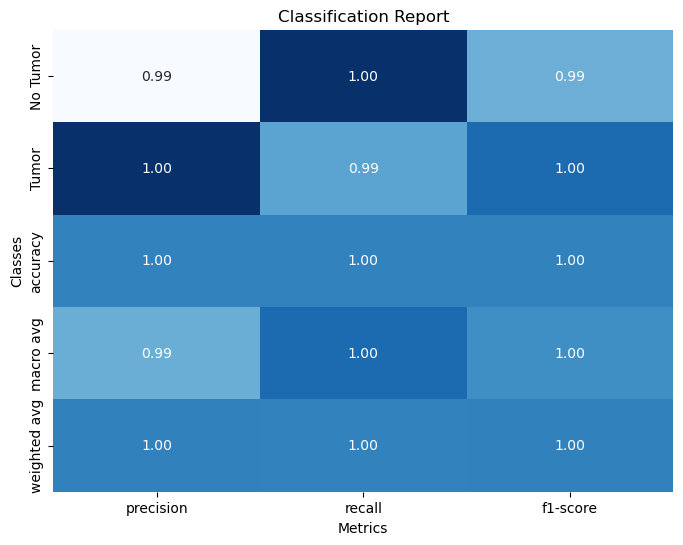

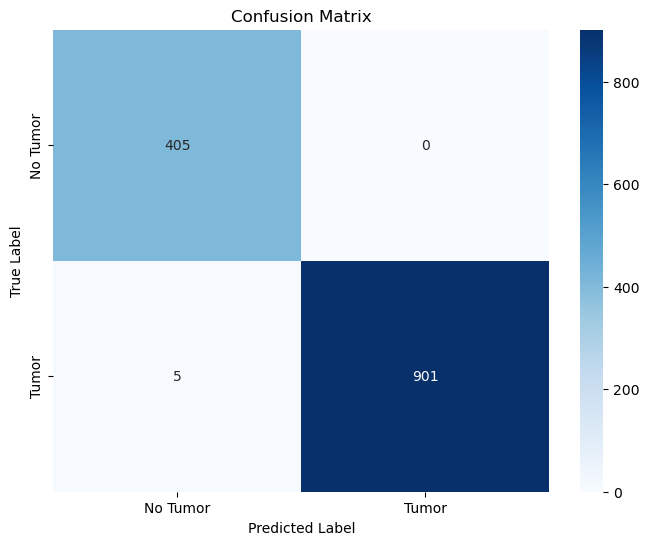

In [6]:
class_names = ['No Tumor', 'Tumor']
create_classification_results(y_true, y_pred, class_names=class_names)

### Multi Classification

In [7]:
train_dataset = TumorClassificationDataset(
    root_dir=DATASET_PATH,
    split=DataSplit.TRAIN,
    transform=transform,
)

test_dataset = TumorClassificationDataset(
    root_dir=DATASET_PATH,
    split=DataSplit.TEST,
    transform=transform,
)

print("Train dataset length: ", len(train_dataset))
print("Test dataset length: ", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Train dataset length:  5712
Test dataset length:  1311


In [8]:
model, criterion, optimizer = build_model_for_job(is_multiclass=True)
model.to(device)
train_classification(
    model,
    train_loader,
    optimizer,
    criterion,
    device,
    N_EPOCHS,
    is_multiclass=True,
    model_path=CNN_MULTI_MODEL
)

Epoch 1/20: 100%|██████████| 179/179 [00:21<00:00,  8.19batch/s, Avg Train Loss=0.8154442067252857, Phase=Train]


Epoch 1/20, Loss: 0.8154442067252857


Epoch 2/20: 100%|██████████| 179/179 [00:21<00:00,  8.35batch/s, Avg Train Loss=0.4697809403335581, Phase=Train] 


Epoch 2/20, Loss: 0.4697809403335581


Epoch 3/20: 100%|██████████| 179/179 [00:21<00:00,  8.37batch/s, Avg Train Loss=0.3502001082264512, Phase=Train] 


Epoch 3/20, Loss: 0.3502001082264512


Epoch 4/20: 100%|██████████| 179/179 [00:21<00:00,  8.17batch/s, Avg Train Loss=0.2593704089522362, Phase=Train] 


Epoch 4/20, Loss: 0.2593704089522362


Epoch 5/20: 100%|██████████| 179/179 [00:21<00:00,  8.26batch/s, Avg Train Loss=0.19641400716532872, Phase=Train]


Epoch 5/20, Loss: 0.19641400716532872


Epoch 6/20: 100%|██████████| 179/179 [00:22<00:00,  8.13batch/s, Avg Train Loss=0.13788557364787465, Phase=Train]


Epoch 6/20, Loss: 0.13788557364787465


Epoch 7/20: 100%|██████████| 179/179 [00:21<00:00,  8.17batch/s, Avg Train Loss=0.11199319676896713, Phase=Train]


Epoch 7/20, Loss: 0.11199319676896713


Epoch 8/20: 100%|██████████| 179/179 [00:21<00:00,  8.15batch/s, Avg Train Loss=0.07953274962830478, Phase=Train]


Epoch 8/20, Loss: 0.07953274962830478


Epoch 9/20: 100%|██████████| 179/179 [00:22<00:00,  8.10batch/s, Avg Train Loss=0.053935300616037574, Phase=Train]


Epoch 9/20, Loss: 0.053935300616037574


Epoch 10/20: 100%|██████████| 179/179 [00:22<00:00,  7.94batch/s, Avg Train Loss=0.03873557188449292, Phase=Train] 


Epoch 10/20, Loss: 0.03873557188449292


Epoch 11/20: 100%|██████████| 179/179 [00:22<00:00,  8.09batch/s, Avg Train Loss=0.025283385490265, Phase=Train]   


Epoch 11/20, Loss: 0.025283385490265


Epoch 12/20: 100%|██████████| 179/179 [00:21<00:00,  8.26batch/s, Avg Train Loss=0.019845023057969848, Phase=Train]


Epoch 12/20, Loss: 0.019845023057969848


Epoch 13/20: 100%|██████████| 179/179 [00:21<00:00,  8.22batch/s, Avg Train Loss=0.009242138264742397, Phase=Train]


Epoch 13/20, Loss: 0.009242138264742397


Epoch 14/20: 100%|██████████| 179/179 [00:21<00:00,  8.22batch/s, Avg Train Loss=0.006528276192770967, Phase=Train] 


Epoch 14/20, Loss: 0.006528276192770967


Epoch 15/20: 100%|██████████| 179/179 [00:21<00:00,  8.18batch/s, Avg Train Loss=0.00549912373613379, Phase=Train]  


Epoch 15/20, Loss: 0.00549912373613379


Epoch 16/20: 100%|██████████| 179/179 [00:21<00:00,  8.16batch/s, Avg Train Loss=0.0031335336797937018, Phase=Train]


Epoch 16/20, Loss: 0.0031335336797937018


Epoch 17/20: 100%|██████████| 179/179 [00:21<00:00,  8.21batch/s, Avg Train Loss=0.0025686443784643576, Phase=Train]


Epoch 17/20, Loss: 0.0025686443784643576


Epoch 18/20: 100%|██████████| 179/179 [00:21<00:00,  8.25batch/s, Avg Train Loss=0.0021742322187390793, Phase=Train]


Epoch 18/20, Loss: 0.0021742322187390793


Epoch 19/20: 100%|██████████| 179/179 [00:21<00:00,  8.34batch/s, Avg Train Loss=0.0018726671262521968, Phase=Train]


Epoch 19/20, Loss: 0.0018726671262521968


Epoch 20/20: 100%|██████████| 179/179 [00:21<00:00,  8.24batch/s, Avg Train Loss=0.001680310312352877, Phase=Train] 


Epoch 20/20, Loss: 0.001680310312352877


In [9]:
# Load the model
model.load_state_dict(torch.load(CNN_MULTI_MODEL))
model.eval()  # Set the model to evaluation mode
model.to(device)

metrics = torchmetrics.MetricCollection(
    [
        MulticlassAUROC(4).to(device),
        MulticlassJaccardIndex(4).to(device),
        MulticlassAccuracy(4).to(device),
        MulticlassF1Score(4).to(device),
        MulticlassPrecision(4).to(device),
        MulticlassRecall(4).to(device),
    ]
)

with torch.no_grad():
    y_true, y_pred, total_metrics = eval_classification(
        model, test_loader, metrics, device, is_multiclass=True
    )

    print(f"Validation Metrics: ", total_metrics)

multi_class_accuracy = total_metrics["MulticlassAccuracy"]
print(f"Multi-class accuracy: {multi_class_accuracy:.2%}")

  0%|          | 0/41 [00:00<?, ?it/s]/home/jhrudd/miniconda3/envs/ai_project_env/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/jhrudd/miniconda3/envs/ai_project_env/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
100%|██████████| 41/41 [00:03<00:00, 10.35it/s]

Validation Metrics:  {'MulticlassAUROC': tensor(0.9927, device='cuda:0'), 'MulticlassJaccardIndex': tensor(0.8960, device='cuda:0'), 'MulticlassAccuracy': tensor(0.9431, device='cuda:0'), 'MulticlassF1Score': tensor(0.9431, device='cuda:0'), 'MulticlassPrecision': tensor(0.9442, device='cuda:0'), 'MulticlassRecall': tensor(0.9431, device='cuda:0')}
Multi-class accuracy: 94.31%


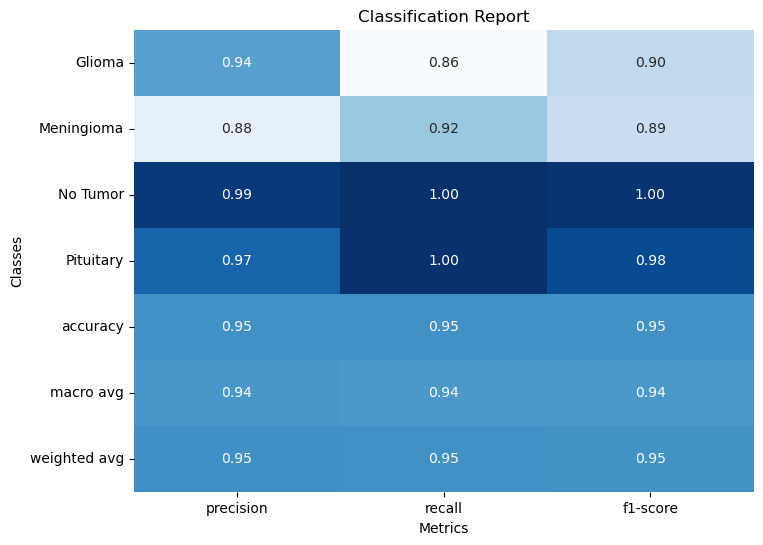

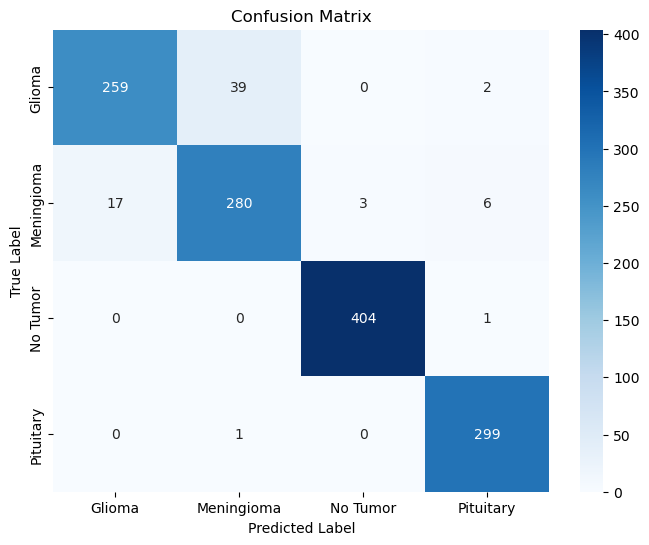

In [10]:
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
create_classification_results(y_true, y_pred, class_names)
